### Explanation
This code analyses time lapse images of plates with growing colonies and get their size and mean fluorescence over time thogheter to some valuable characterization of their dynamics. It uses the module python FluoPi to perform these tasks.

##### Requirements
 - All images have to be same size


## Analysis

### Loading packages
As part of the FluoPi project we provide a python module to manage and analyse time lapse data. We will also use some common modules for plotting and analysing data:

In [1]:
# Import the FluoPi module
import fluopi

# import some useful packages to manage the data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading Data

Specifying the folder name where the images are stored, we can count the files:

In [2]:
fpath = '../Lab_27_1_17_pLac'
imCount = fluopi.count_files(fpath, 'jpg')

../Lab_27_1_17_pLac = 0 files


In [2]:
fpath = 'D:\Dropbox\FTI\Raspiscope\Time lapse\Lab_27_1_17_pLac'
imCount = fluopi.count_files(fpath, 'jpg')

Lab_27_1_17_pLac = 600 files


The FluoPi module provides a function to read images and save their values in 3-dimensional arrays (one for each channel). Now we can use this function to read and store the data of the images on a defined array for each channel:

In [3]:
import os
fname = os.path.join(fpath, 'image_%04d.jpg')

Frames=12   # use one image every 12 frames

DataS={}
DataS['R'],DataS['G'],DataS['B'] = fluopi.get_im_data(Frames,imCount,fname)
DataS['Im']=fname     # to store the related image source

# also define a vector with the channels
channels=['R','G','B']

Finally is important know the time step value used on the timelapse. It can be know from the python timelapse code stored on the folder (named 'interval' on the code).

In [4]:
#define it on hour units
dT= 1.0/12.0  #hours

#in this example interval = 5 min for each frame


With this, we can construct a **time vector** 'T' for *DataS*

In [5]:
w,h,st=DataS['R'].shape
T=np.zeros((st))
for i in range(0,st):
    T[i]=(i)*Frames*dT

print(T)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.]


### Data management

#### Background computation and substraction

To take the valuable data of images is good to know the amount of background we have on it, if it changes over time or how noisy is it.

By ploting a transect of pixel values for each channel on an image, we can figure the efect of background: 

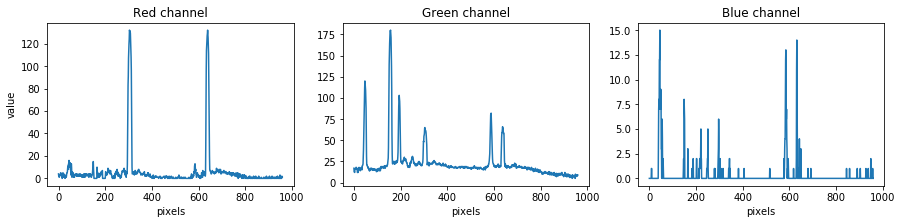

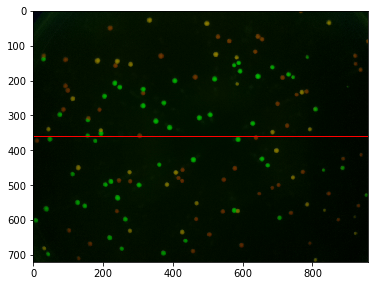

In [6]:
fluopi.row_transect(DataS, row=int(w/2), xframes=10)

As you can see, data shows "peaks" (colonies) and a basal value along the line (background signal)

Then, to distinguish cell fluorescence from media and background light, we can select some empty sector on the image (i.e. without colonies) and compute his mean value on each frame.

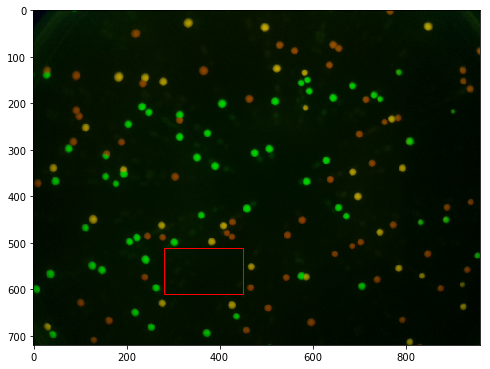

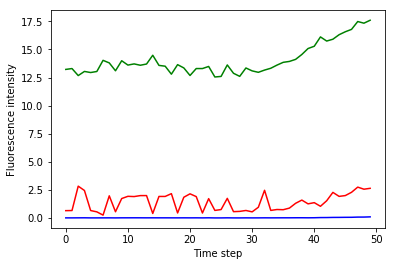

In [7]:
BG = fluopi.BG_Val(512, 610, 280, 450, DataS, imCount)

We can substract this background value from each frame using BG_subst:

In [8]:
DataSB = fluopi.BG_subst(DataS,BG)

and we can check the effect on the background

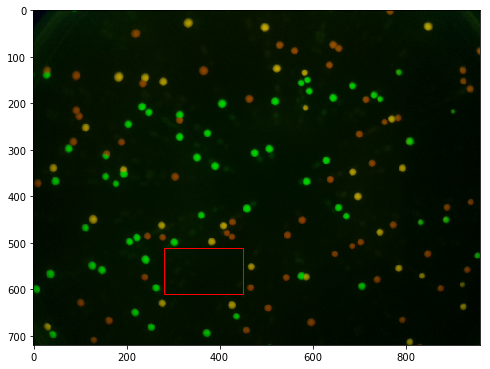

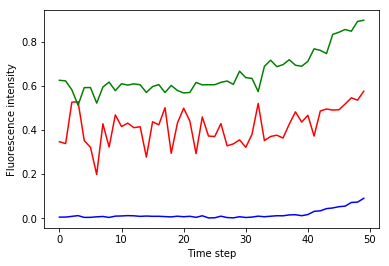

In [9]:
_ = fluopi.BG_Val(512, 610, 280, 450, DataSB, imCount)

Background was practically eliminated.

### Get colony position
Here we are interested on identify the place where colonies are situated

A good way to do it is by sum the value of each pixel for all the channels and all the frames

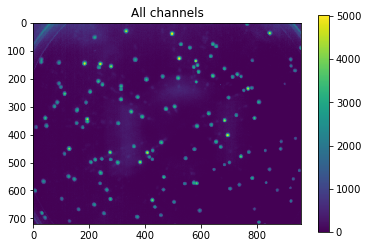

In [10]:
SumData = fluopi.dataOT(DataSB)

Now we can see each colony as a more clear point

#### Filter application
To improve the border detection and reduce the noise is recommended  to apply a filter to smooth the data. A simple and effective gaussian filter is provided by skimage package:
[skimage gaussian filter](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian)

In [11]:
from skimage.filters import gaussian

The effect of the filter can be understood with the next example:

In [12]:
#see the effect of the filter
a = np.zeros((3, 3))
a[1,1]=1
print(a)
gaussian(a, sigma=1)

[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]


array([[ 0.05855018,  0.09653293,  0.05855018],
       [ 0.09653293,  0.15915589,  0.09653293],
       [ 0.05855018,  0.09653293,  0.05855018]])

Then we apply a the filter to the data:

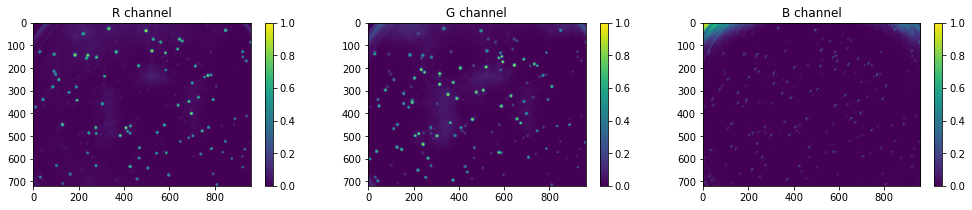

In [13]:
sDatS,sDatSall,sDatST=fluopi.smoothDat(DataSB,0.7)

And we can see the plot of the sumarized result

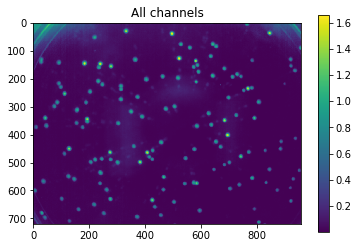

In [14]:
plt.imshow(sDatSall)
plt.colorbar()
plt.title('All channels')

#### Blob detection
Scikit-image provides several functions to detect Gaussian-like features ([blobs](http://scikit-image.org/docs/dev/auto_examples/plot_blob.html)). We apply one of these ([blob_log](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log)) to the smoothed sum of intensity, and it returns a list of position (x,y) and width (standard deviation):

To properly identification, it's important to set the threshold for each dataset manually (based on the previous colormap)

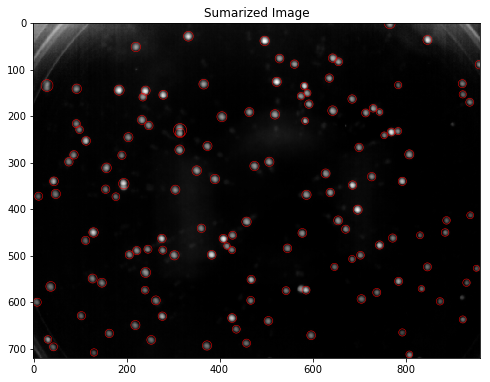

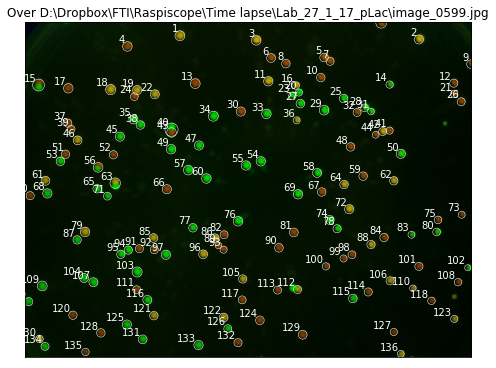

In [15]:
blobD = fluopi.colonyBlob(sDatSall,0.26,fname%599)

With the previous procedure we have identificated where each colony is placed

To perform further analysis on each colony is necesary to store these regions of interest (ROI) and his data, with size given by the Gaussian width (x2 = 2 standard deviations).

In [16]:
Rois,RoisC,NC = fluopi.obtain_rois(sDatST,blobD)

D:\Dropbox\Tim proyects\RaspiscopeFolders\Raspiscope\Examples\fluopi\__init__.py:504: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rois[i] = data[char][x1:x2,y1:y2,:]


we can ilustrate the data with the first blob (colony)

In [17]:
# show the first column of the first ROI
print(Rois['R'][0][:,1,1])
print(RoisC['R'][0][:,1,1]) #it contains only the pixels inside the circular region, and make the other equal to zero

[ 0.56347187  0.7433185   1.44368679  2.13841856  1.80108089  0.69087143
  0.2878914   0.22028745  0.21336238  0.26223675  0.39719581  0.6014094 ]
[ 0.          0.          0.          2.13841856  1.80108089  0.69087143
  0.2878914   0.22028745  0.21336238  0.26223675  0.          0.        ]


### Time dynamics of colonies
As we have estimated colony location (and maximmum size), we can analyse the dynamics of fluorescence and growth of them. 

#### Fluorescence dynamics
with the data obtained to this point we should be able to plot the fluorescence dynamics of colonies. We can choose a some representative colonies and use the FluoPi rois_plt_Fdynam() function to perform this task:

Each line correspond to a different ROI


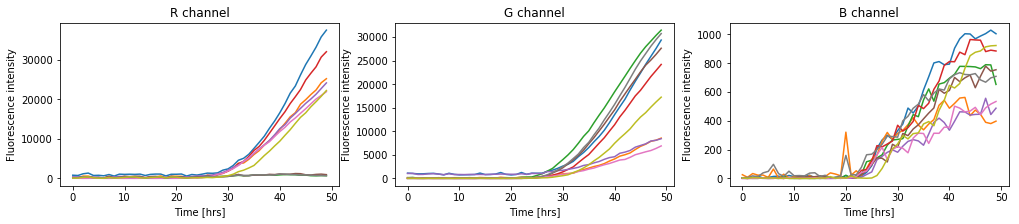

In [18]:
#define the selected colonies
Cols=[1,17,45,79,66,125,81,109,121]

#use the function to plot
fluopi.rois_plt_Fdynam(RoisC,T,Cols)
print('Each line correspond to a different ROI')

#### Colony radius growth
We have the location and some kind of size estimate based on the total fluorescence of each colony over the time-lapse. We would like to know the size of the colony in each frame; from this we can compute the growth rate.

One way to do this is to find Gaussian blobs in each of the image regions of the colony, for each frame of the time-lapse.This is very slow

First we perform the sum of all channels for each frame to get the best representation of colony size:

In [ ]:
ACRois=fluopi.channelSum(RoisC,Cols) #circular ROIS

In [19]:
ACRoisS=fluopi.channelSum(Rois,Cols) #square ROIS

The following loop finds blobs and stores the width in each frame. The result is a dict containing the size at each time point for every colony

In [ ]:
R_frame=frame_colony_size(ACRois,Cols,0.25)

In [ ]:
R_frame=frame_colony_size(ACRois,Cols,0.28)

In [ ]:
import time

start = time.time()
R_frame2=frame_colony_size(ACRois,NC,0.45)
end = time.time()
print((str((end - start)/60))+' minutes')

In [23]:
start = time.time()
R_frame3=fluopi.frame_colony_size(ACRoisS,Cols,0.32)
end = time.time()
print((str((end - start)/60))+' minutes')

0.5678491433461507 minutes


In [20]:
import time
start = time.time()
R_frame4=fluopi.frame_colony_size(ACRoisS,Cols,0.35)
end = time.time()
print(end - start)

31.44579839706421


In [26]:

start = time.time()
R_frame5=fluopi.frame_colony_size(ACRoisS,Cols,0.37)
end = time.time()
print(end - start)

32.44485569000244


Since the colony is roughly circular and flat, an estimate of volume is $R^2$. Lets plot this for some colonies. Plotting the log is useful because the slope is the relative growth rate. We can see the colonies slow their growth during the experiment.

In [ ]:
plot_growth(R_frame,T)
print('Each line correspond to one colony')

In [ ]:
plot_growth2(R_frame2,T)

In [ ]:
plot_growth(R_frame2,T)
print('Each line correspond to one colony')

In [ ]:
plot_growth(R_frame3,T)


In [ ]:
plot_growth2(R_frame3,T)

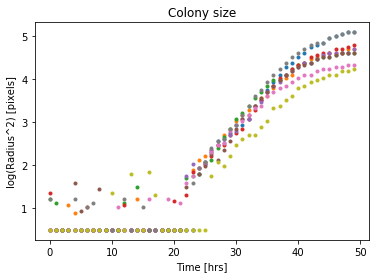

In [27]:
fluopi.plot_growth(R_frame3,Cols,T)

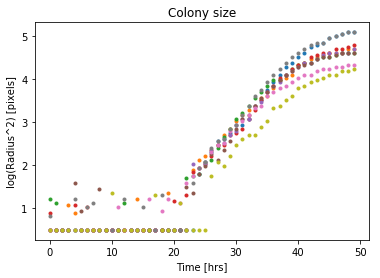

In [21]:
fluopi.plot_growth(R_frame4,Cols,T)


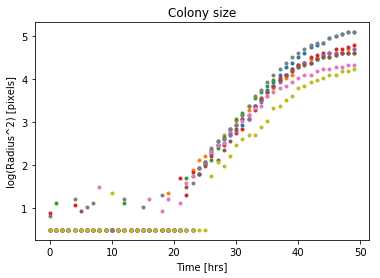

In [28]:
fluopi.plot_growth(R_frame5,Cols,T)

#### Check the radius estimate
To see how well the colony size is estimated, we can compare to the profile of a colony in a slice of its image region. The radius (red line) should give the border of the colony.

In [ ]:
IDCol=50
plt.figure()
plt.imshow(ACRoisS[IDCol][5,:,:], interpolation='none', cmap='gray')
plt.figure()
plt.imshow(ACRois[IDCol][5,:,:], interpolation='none', cmap='gray')
plt.figure()
plt.imshow(ACRois[IDCol][:,:,-1], interpolation='none', cmap='gray')

D:\Dropbox\Tim proyects\RaspiscopeFolders\Raspiscope\Examples\fluopi\__init__.py:714: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  plt.imshow(rois[idx][w/2+1,:,:], interpolation='none', cmap='gray') # use the x-middle transect (--> w/2+1)


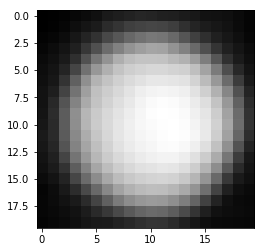

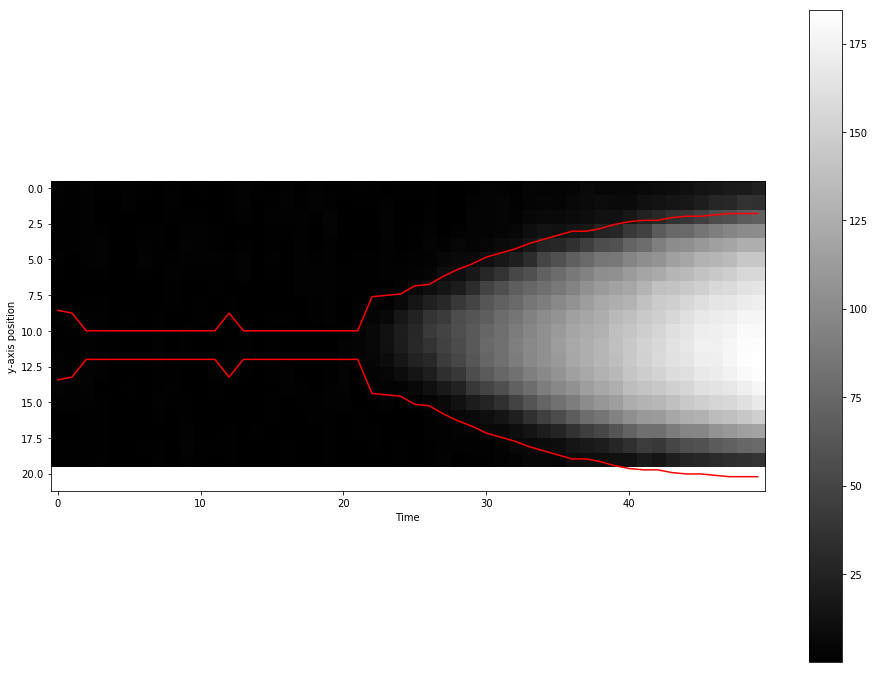

In [44]:
IDCol=Cols[2]
plt.figure()
plt.imshow(ACRoisS[IDCol][:,:,-1], interpolation='none', cmap='gray')

fluopi.checkR(R_frame4,ACRoisS,IDCol,T)


To improve determination of radio we can fix a monotonically incresing function to the obstained values for each colony. This function could be of sigmodial type:
\begin{equation}
r(t) = \frac{a}{1+ e^{-d(t+b)}}
\end{equation}

Tuve que hacer el fitting a partir del punto 19 (punto desidido a partir del grafico de los radios) por ser el momento donde se supera el "ruido"

You can se the effect of the parameters evaluating the function F_sigma:

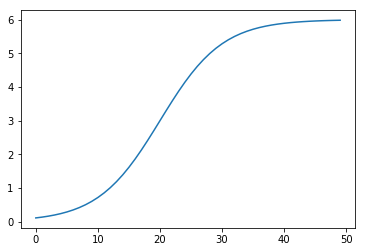

In [54]:
Sigmoid=fluopi.F_sigma(T, 6, -20, 0.2)
plt.plot(T,Sigmoid)

With the function Function_fit you can fit the mathematical model to one seleceted colony:

[  4.7222736  -26.61714276   0.17176503]


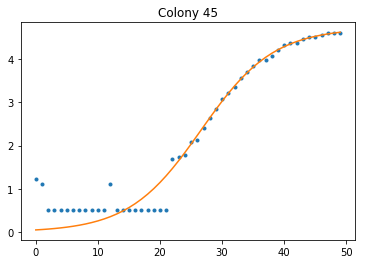

In [65]:
idx=Cols[2]
init=23
end=-1
SingleF,_=fluopi.Function_fit(T,R_frame4[idx],init,end,idx)

or you can perform the fit to (more than one) selected colonies with the function Fit_radio:

[  5.18126834 -28.98893195   0.17633907]


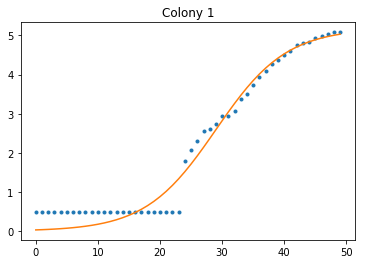

[  4.80030178 -27.04007132   0.16202492]


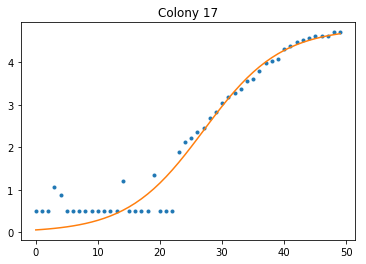

[  4.75632582 -26.57261082   0.16434752]


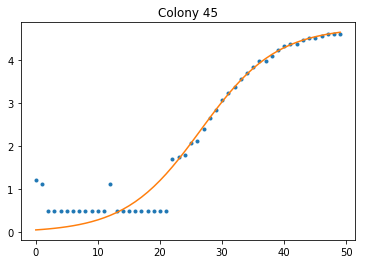

[  5.14107724 -28.36720183   0.13605806]


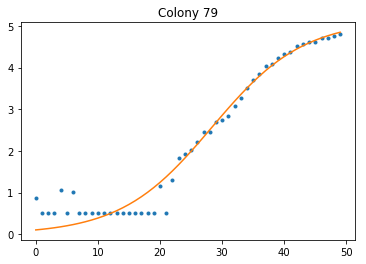

[  4.82492142 -27.53160822   0.16051952]


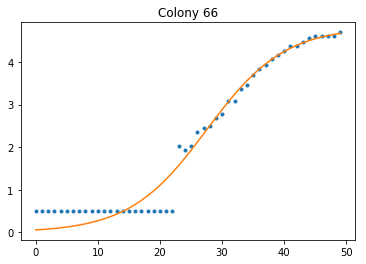

[  4.82407565 -27.71330547   0.16075294]


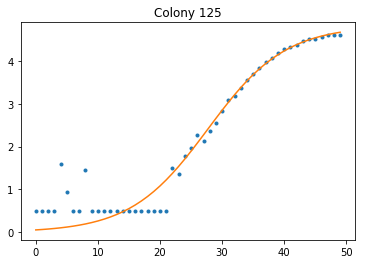

[  4.48234872 -25.91356749   0.14976744]


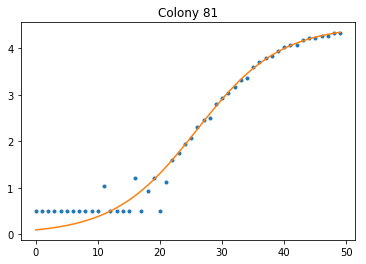

[  5.1899082  -28.12235131   0.17358098]


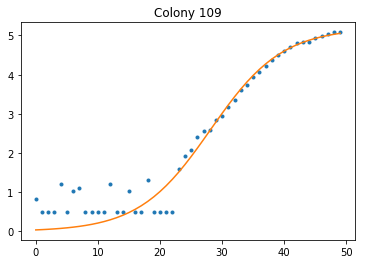

[  4.11774816 -29.27695575   0.22970313]


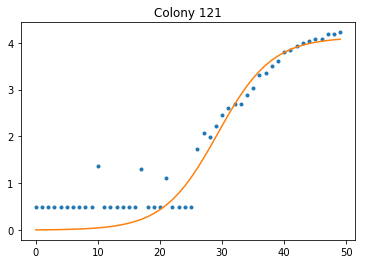

In [61]:
init=22
end=-1
R_fitS=fluopi.fit_radio(T,R_frame4,Cols,init,end)

Now we should export and save our results. For this aim, is good to put fluorescence and size in the same dictionary:

In [ ]:
# I think is good to save the time vector, the 
def Final_Data(rois,R,t,nc)
    Gdat = {}
    for i in nc:
        GDat[i]= np.zeros((rois[i].shape,len(R),len(t)))
        

In [ ]:
import csv

In [ ]:
w = csv.writer(open("output.csv", "w"))
for key, val in dict.items():
    w.writerow([key, val])

In [ ]:
%matplotlib auto
idx=66
plt.figure(figsize=(12,10))
for i in range(T.shape[0]):

            #plt.imshow(rois[idx+20][:,:,-1], interpolation='none', vmin=0, vmax=mx)
            #plt.colorbar()
    roi = ACRoisS[idx][:,:,i]
    plt.imshow(roi, interpolation='none', vmin=0, vmax=255,cmap='gray')
    
    # Uncomment here to save figures as images
    #plt.savefig('AnalysisOutput/rois2/rois_step%d.png'%(i))
    #plt.title('Colonies 1-20')
    plt.pause(0.1)
%matplotlib inline

In [ ]:
%matplotlib inline
idx=66
Times=[14,24,29,34,39,44,49]
for i in Times :

            #plt.imshow(rois[idx+20][:,:,-1], interpolation='none', vmin=0, vmax=mx)
            #plt.colorbar()
    plt.figure(figsize=(8,8))        
    roi = ACRoisS[idx][:,:,i]
    plt.imshow(roi, interpolation='none', vmin=0, vmax=255,cmap='gray')
    plt.colorbar()
    # Uncomment here to save figures as images
    plt.savefig('singlecol/rois_step%d.png'%(i+1))
    #plt.title('frame'+str(i+1))

In [ ]:
print(T)

### Parameter estimation from data

We now have information about sub-populations of bacteria (colonies) on the same plate. The fluorescence in each region of interest estimates the time varying fluorescent protein level in each colony. The radius (or $R^2$) approximates the size of each sub-population (colony) and so is similar to optical density (OD) in a bulk plate-reader experiment. 

Lets write a simple model of fluorescent protein expression from a single cell:

\begin{equation}
\frac{dF}{dt} = k(t) - (\mu(t) + \delta(t))F
\end{equation}

where $F$ is the cell's fluorescent protein concentration, which is produced at time-varying rate $k(t)$. The cell grows at relative rate $\mu(t)=(1/V)dV/dt$ ($V=$volume) causing dilution, but assuming a constant thickness of the colony it becomes proportional to the area: $\mu(t)=(1/A)dA/dt$ ($A=$area). 
The protein is degraded at rate $\delta(t)$.


For the proteins we are using we will assume that $\delta(t)=0$ for all times. We measure the total fluorescence intensity, which is the concentration $F$ multiplied by the total volume of the colony $A_{tot} = \pi R^2$. Hence,

\begin{equation}
I(t) = F(t)A(t) \approx F(t) \pi R^2(t)
\end{equation}

From these equations it is possible to derive:

\begin{equation}
k(t) = \frac{1}{A(t)}\frac{dI}{dt}
\end{equation}

Lets get $V$ and $I$ from our data:

In [ ]:
R_fitS[1][1]

In [ ]:
import math
from math import pi

# Approximate volume as Pi*R^2
A = {}
for i in range(NC):
    r=R_fitS[i][0]
    A[i] = pi*r*r
    


In [ ]:
plt.figure()
for i in range(NC):
    plt.plot(T,A[i],'-')
plt.xlabel('Time [h]')
plt.ylabel('Area [pixels^2]')
plt.title('Colony growth')

In [ ]:
# Get total fluorescence intensity for each colony, summing over all pixels in the region
I = {}
plt.figure()
for i in range(NC):
    I[i]=ACRoisS[i].sum(axis=(0,1))
    plt.plot(T,I[i],'.')

In [ ]:
plt.figure(figsize=(12,9))
for i in range(NC):
    
    intensity = I[i]
    area = A[i][1:]
    delta_I = np.diff(intensity)
    #print(delta_I)
    delta_T=np.diff(T)
    k = (delta_I/delta_T)/area
    plt.subplot(311)
    plt.plot(T[30:],k[29:],'-')
    
    plt.ylabel('k(t)')
    plt.ylim([-30,150])
    plt.subplot(312)
    plt.plot(delta_I)
    plt.ylabel('delta I')
    plt.subplot(313)
    plt.plot(intensity)
    plt.ylabel('Intensity')
    plt.xlabel('Time (h)')

the problem of this aproach is we cannot get the proper values at the beggining, because the area is less than 1, then it makes the k(t) value growth

Another way to do this task is by doing the division between the intensity and the volume first, then take his rate

In [ ]:
plt.figure(figsize=(12,8))
for i in range(NC):
    
    intensity = I[i]
    area = A[i]
    I_A=intensity/area
    delta_IA = np.diff(I_A)
    #print(delta_I)
    delta_T=np.diff(T)
    k = delta_IA/delta_T
    plt.subplot(311)
    plt.plot(T[1:],k,'-')
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    plt.ylim([-50,100])
    plt.subplot(312)
    plt.plot(T[1:],delta_IA)
    plt.ylim([-100,150])
    plt.subplot(313)
    plt.plot(intensity)

This is worst! using the volumen first only aplify the noise in the diference computation step

My final approach is to compute the average value inside the ROIS, but compute the ROISwith the fitted area.
This average value correspond to I/A.
Doing the proper maths 

In [ ]:
for i in range(NC)
ACRoisS[]

In [ ]:
len(R_fitS[1][0])

In [ ]:
def CRoiInt_frames(data,blobs,R):
 #inputs
    # data = matrix with sum in channels and time of the images
    # blobs = matrix with all the information of the obtainesd blobls (output from colonyBlob function)
 #return
    # all_rois = array with the information of the region of interest (square arund the colony)
    # all_rois_circle = array with the information inside the area of the colony (makes the values outside the colony equals to zero)
    # nc = number of colonies ( equals to the length of rois vector) 
    all_rois = {}
    all_rois_circle = {}
    nc= len(blobs)
    
    for char in channels:
        CroisVal = {}
        
        for i in range(nc):
            x = blobs[i,0]
            y = blobs[i,1]
            CRoiInt=0
            count=0
            meanInt=np.zeros((len(R[i][0])))
            
            for j in range(len(R[i][0])): 
####### this lines is to eliminate the out of image bounds error
                r=R[i][0][j]
    
                x1=x-r
                x2=x+r
                y1=y-r
                y2=y+r

                if x1 <= 0:
                    x1 = 0
                if x2 >= data[char].shape[0]:
                    x2 = data[char].shape[0]
                if y1 <= 0:
                    y1 = 0
                if y2 >= data[char].shape[1]:
                    y2 = data[char].shape[1]

                SRoi = data[char][x1:x2,y1:y2,j]

#######            
                xr=int((SRoi.shape[0]+1)/2)
                yr=int((SRoi.shape[1]+1)/2)
                
                for n in range(SRoi.shape[0]):
                    for m in range(SRoi.shape[1]):
                        if ((n-xr)**2+(m-yr)**2) <= (r**2):
                            CRoiInt += SRoi[n,m]
                            count+=1
                if count != 0:
                    meanInt[j]=CRoiInt/count
            CroisVal[i]=meanInt
        all_rois_circle[char] = CroisVal
    
    return(all_rois_circle)

# rois contains a square arund the colony
# roisC makes the values outside the colony equals to zero

# to call it:
# roisC['channel_name'][blob_number][y,x,timepoint]

In [ ]:
MeanInt=CRoiInt_frames(sDatST,blobD,R_fitS)

In [ ]:
plt.plot(T,MeanInt['R'][90],'.')

In [ ]:
#let's sum the three channels
MeanInt3C={}
for i in range(NC):
    Vaux=np.zeros((MeanInt['R'][i].shape))
    for c in channels:
        Vaux+=MeanInt[c][i]
    
    MeanInt3C[i]= Vaux

In [ ]:
plt.figure()
for i in range(NC):
    plt.plot(T,MeanInt3C[i],'.')
    plt.title('Mean Fluorescence')
    plt.xlabel('Time [h]')
    plt.ylabel('Intensity [RGB value]')
    
print('this plot contain the sum of the mean of the three channels over time for each colony')

In [ ]:
dIAdt={}
plt.figure(figsize=(12,8))
for i in range(NC):
    #delta_MeanInt3C is the intensity divided by the area = d(I/A)/dt
    delta_MeanInt3C = np.diff(MeanInt3C[i])
    delta_T=np.diff(T)
    dIAdt[i] = delta_MeanInt3C/delta_T
    plt.plot(T[1:],dIAdt[i],'-')
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.ylim([-5,20])

Now i should try the smooth splite to correct the estimation.
Also we should try to get the $\mu(t)=(1/A)dA/dt$
that is equal to: $$\mu = \frac{2 \cdot d}{e^{d \cdot (t+b)}+1} $$

In [ ]:
#as we knnow the analytic equation of mu
def F_mu (t,b,c):
    return((2 *c /(np.exp(c*(t+b))+1)))

In [ ]:
Mu_val={}
for i in range(NC):
    Mu_val[i]=F_mu(T,R_fitS[i][1][1],R_fitS[i][1][2])
    plt.plot(T,Mu_val[i],'-')
    plt.xlabel('Time (h)')
    plt.ylabel('mu(t)')
    plt.xlim([0,50])
    plt.ylim([0,1])


In [ ]:
R_fitS[1][1][1]

In [ ]:
np.diff(T)

## Data smoothing

In [ ]:
from scipy.interpolate import UnivariateSpline

[Univariate Spline Documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.interpolate.UnivariateSpline.html)

In [ ]:
dIAdt_smooth={}
for i in range(NC):
    dIAdt_smooth[i] = UnivariateSpline(T[1:],dIAdt[i])
    dIAdt_smooth[i].set_smoothing_factor(1e7)
    plt.plot(T[:],dIAdt_smooth[i](T[:]),'-')
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    #plt.ylim([-5,20])

In [ ]:
#See the smooth
dIAdt_smooth[1](T[:])

Finally, the fluorescent expresion rate constant could be represented by: $$ K_f = \frac{d(I/A)}{dt} + \mu \cdot (I/A) $$

In [ ]:
Kf={}
for i in range(NC):
    Kf[i]=dIAdt_smooth[i](T[:])+Mu_val[i]*MeanInt3C[i]
    plt.plot(T[:],Kf[i],'-')
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    plt.ylim([-1,30])

In [ ]:
len(MeanInt3C[1])

Ahora deberia computar las circular ROIS para cada tiempo con las nuevas áreas de los radios obtenidos.

In [ ]:
def rois_frames(data,blobs,R):
 #inputs
    # data = matrix with sum in channels and time of the images
    # blobs = matrix with all the information of the obtainesd blobls (output from colonyBlob function)
 #return
    # all_rois = array with the information of the region of interest (square arund the colony)
    # all_rois_circle = array with the information inside the area of the colony (makes the values outside the colony equals to zero)
    # nc = number of colonies ( equals to the length of rois vector) 
    all_rois = {}
    all_rois_circle = {}
    nc= len(blobs)
    
    for char in channels:
        rois = {}
        rois_circle = {}
        
        for i in range(nc):
            x = blobs[i,0]
            y = blobs[i,1]
            for j in range(len(R[i][0])): 
####### this lines is to eliminate the out of image bounds error
                r=R[i][0][j]
    
                x1=x-r
                x2=x+r
                y1=y-r
                y2=y+r

                if x1 <= 0:
                    x1 = 0
                if x2 >= data[char].shape[0]:
                    x2 = data[char].shape[0]
                if y1 <= 0:
                    y1 = 0
                if y2 >= data[char].shape[1]:
                    y2 = data[char].shape[1]

                rois[i] = data[char][x1:x2,y1:y2,:]    
#######            
                xr=int((rois[i].shape[0]+1)/2)
                yr=int((rois[i].shape[1]+1)/2)
                rois_circle[i]=np.zeros((rois[i].shape))
                for n in range(rois[i].shape[0]):
                    for m in range(rois[i].shape[1]):
                        if ((n-xr)**2+(m-yr)**2) <= (r**2):
                            rois_circle[i][n,m,j] = rois[i][n,m,j]
        all_rois[char] = rois
        all_rois_circle[char] = rois_circle
    
    return(all_rois,all_rois_circle)

# rois contains a square arund the colony
# roisC makes the values outside the colony equals to zero

# to call it:
# roisC['channel_name'][blob_number][y,x,timepoint]

In [ ]:
SRoisF,CRoisF=rois_frames(sDatST,blobD,R_fitS)

In [ ]:
np.meanCRoisF

In [ ]:
IDCol=50
plt.imshow(SRoisF['G'][IDCol][5,:,:], interpolation='none', cmap='gray')

In [ ]:
test=np.zeros((len(R_fitS[1][0])))
print(test)

fin

In [ ]:
1+1